In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, time, json, re, copy
import itertools, argparse, pickle, random

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, sampler

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Loading data, preprocessing and batchifying

### Download data

In [0]:
path = '/content/data'
if not os.path.exists(path): os.mkdir(path)
os.chdir(path)

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [6]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -f train.csv

 34% 9.00M/26.3M [00:00<00:00, 22.3MB/s]
100% 26.3M/26.3M [00:00<00:00, 44.9MB/s]


In [7]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -f test.csv

 38% 9.00M/23.4M [00:00<00:01, 13.7MB/s]
100% 23.4M/23.4M [00:00<00:00, 25.4MB/s]


In [8]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [9]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!rm train.csv.zip test.csv.zip

### Loading and preprocessing

In [0]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_punc(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def clean_text(raw):
    return clean_numbers(clean_punc(raw.lower()))


def word_idx_map(raw_comments, vocab_size):
    texts = []
    for c in raw_comments:
        texts.append(c.split())
    word_freq = nltk.FreqDist(itertools.chain(*texts))
    vocab_freq = word_freq.most_common(vocab_size-2)
    idx_to_word = ['<pad>'] + [word for word, cnt in vocab_freq] + ['<unk>']
    word_to_idx = {word:idx for idx, word in enumerate(idx_to_word)}

    return idx_to_word, word_to_idx


def tokenize(comments, word_to_idx, maxlen):
    '''
    Tokenize and numerize the comment sequences
    Inputs:
    - comments: pandas series with wiki comments
    - word_to_idx: mapping from word to index
    - maxlen: max length of each sequence of tokens

    Returns:
    - tokens: array of shape (data_size, maxlen)
    '''

    tokens = []
    for c in tqdm(comments.tolist()):
        token = [(lambda x: word_to_idx[x] if x in word_to_idx else word_to_idx['<unk>'])(w) \
                 for w in c.split()]
        if len(token) > maxlen:
            token = token[-maxlen:]
        else:
            token = [0] * (maxlen-len(token)) + token
        tokens.append(token)
    return np.array(tokens).astype('int32')

In [12]:
%%time
train_df = pd.read_csv(os.path.join(path,'train.csv'))
test_df = pd.read_csv(os.path.join(path,'test.csv'))

CPU times: user 1.27 s, sys: 156 ms, total: 1.43 s
Wall time: 1.43 s


In [13]:
%%time
tqdm.pandas()
train_df['comment_text'] = train_df['comment_text'].progress_apply(clean_text)
test_df['comment_text'] = test_df['comment_text'].progress_apply(clean_text)


CPU times: user 27.3 s, sys: 174 ms, total: 27.5 s
Wall time: 27.4 s


In [14]:
%%time
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
vocab_size = 60000
max_len = 150

train_tars = train_df[label_cols].values.astype('int8')
idx_to_word, word_to_idx = word_idx_map(train_df['comment_text'], vocab_size)
train_seq = tokenize(train_df['comment_text'], word_to_idx, max_len)
x_test = tokenize(test_df['comment_text'], word_to_idx, max_len)


CPU times: user 29.3 s, sys: 978 ms, total: 30.3 s
Wall time: 30.3 s


### train/val split

In [0]:
train_seq.shape, train_tars.shape, x_test.shape, len(word_to_idx)

((159571, 150), (159571, 6), (153164, 150), 60000)

In [0]:
train_tars.mean(0)

array([0.09584448, 0.00999555, 0.05294822, 0.00299553, 0.04936361,
       0.00880486])

In [0]:
np.random.seed(135)
mask = np.random.rand(len(train_seq)) < 0.8
x_val = train_seq[~mask]
x_train = train_seq[mask]
y_val = train_tars[~mask]
y_train = train_tars[mask]

In [0]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((127690, 150), (127690, 6), (31881, 150), (31881, 6))

In [0]:
y_train.mean(0), y_val.mean(0)

(array([0.0952463 , 0.00964837, 0.05256481, 0.00300728, 0.04925209,
        0.00867727]),
 array([0.09824033, 0.01138609, 0.05448386, 0.00294846, 0.04981023,
        0.00931589]))

In [0]:
from sklearn.model_selection import KFold, StratifiedKFold

skf = KFold(n_splits=5, shuffle=True, random_state=135)
cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in skf.split(train_seq, train_tars)]
train_tars[cv_indices[4][0]].mean(0), train_tars[cv_indices[4][1]].mean(0)

(array([0.09577226, 0.00994853, 0.05318157, 0.00303939, 0.04933533,
        0.00897718]),
 array([0.09613336, 0.01018362, 0.05201479, 0.00282008, 0.04947672,
        0.00811556]))

### data loader

In [0]:
class Toxic_comments(Dataset):

    def __init__(self, tokenized_comments, targets=None):
        self.comments = tokenized_comments
        self.targets = targets

    def __getitem__(self, index):
        comment = self.comments[index]
        if self.targets is not None:
            target = self.targets[index]
            return torch.LongTensor(comment), torch.FloatTensor(target)
        else:
            return torch.LongTensor(comment)

    def __len__(self):
        return len(self.comments)


def prepare_loader(x, y=None, batch_size=1024, train=True):
    data_set = Toxic_comments(x, y)
    if train:
        return DataLoader(data_set, batch_size=batch_size, shuffle=True)
    else:
        return DataLoader(data_set, batch_size=batch_size)

In [0]:
train_loader = prepare_loader(x_train, y_train, 32)
x_b, y_b = next(iter(train_loader))
x_b.shape, y_b.shape

(torch.Size([32, 150]), torch.Size([32, 6]))

## Load embeddings

In [0]:
# Load pre-trained word vector
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embedding(embedding_file, embedding_dim, word_to_idx, vocab_size):
    with open(embedding_file, encoding="utf8", errors='ignore') as f:
        embeddings_index = dict(get_coefs(*o.split(' ')) for o in tqdm(f) if len(o)>100)
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    nb_words = min(vocab_size, len(word_to_idx))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))
    for word, i in tqdm(word_to_idx.items()):
        if i >= vocab_size: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [20]:
os.chdir('/content/drive/My Drive/DL_projects/nlp_toxic_comments')
os.listdir('../Data/wordvecs')

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'GoogleNews-vectors-negative300',
 'glove.840B.300d',
 'paragram_300_sl999',
 'wiki-news-300d-1M']

In [0]:
%%time
EMBEDDING_FILE_GV = '../Data/wordvecs/glove.840B.300d/glove.840B.300d.txt'
EMBEDDING_FILE_PR = '../Data/wordvecs/paragram_300_sl999/paragram_300_sl999.txt'
EMBEDDING_FILE_FT = '../Data/wordvecs/wiki-news-300d-1M/wiki-news-300d-1M.vec'
embed_mat_1 = get_embedding(EMBEDDING_FILE_GV, 300, word_to_idx, vocab_size)
embed_mat_2 = get_embedding(EMBEDDING_FILE_PR, 300, word_to_idx, vocab_size)
#embed_mat_3 = get_embedding(EMBEDDING_FILE_FT, 300, word_to_idx, vocab_size)
embed_mat = np.mean([embed_mat_1, embed_mat_2], 0)


CPU times: user 9min 2s, sys: 47 s, total: 9min 49s
Wall time: 13min


In [0]:
%%time
EMBEDDING_FILE = '../Data/wordvecs/glove.840B.300d/glove.840B.300d.txt'
embed_mat = get_embedding(EMBEDDING_FILE, 300, word_to_idx, vocab_size)


CPU times: user 3min 31s, sys: 23.2 s, total: 3min 55s
Wall time: 4min 28s


In [0]:
embed_mat.shape

(60000, 300)

## Model

In [0]:
class CommentNet(nn.Module):

    def __init__(self, embed_dim, hidden_dim, vocab_size, embed_matrix=None):
        super(CommentNet, self).__init__()
        # Record the arguments
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        # Init layers
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.dropout_seq = nn.Dropout2d(0.25)
        
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_dim*2, hidden_dim, bidirectional=True, batch_first=True)
        
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_dim*4, 6)

        # Weight initialization
        if embed_matrix is not None:
            self.emb.weight = nn.Parameter(torch.tensor(embed_matrix, dtype=torch.float32))
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            if 'weight_hh' in name:
                nn.init.orthogonal_(param)

        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            if 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, seq):
        emb = self.emb(seq)
        emb = self.dropout_seq(emb.transpose(1,2).unsqueeze(-1)).squeeze(-1).transpose(1,2)
        o_lstm, _ = self.lstm(emb)
        o_gru, _ = self.gru(o_lstm)

        # pooling
        avg_pool = torch.mean(o_gru, 1)
        max_pool, _ = torch.max(o_gru, 1)
        x = torch.cat((avg_pool, max_pool), 1)
        out = self.out(self.dropout(x))

        return out

In [0]:
def model_test():
    x = torch.zeros((64, 40), dtype=torch.long)
    x = x.to(device=device)
    
    model = CommentNet(300, 48, vocab_size, embed_mat)
    model = model.to(device=device)
    scores = model(x)
    print(scores.size())

model_test()

torch.Size([64, 6])


## Training the model

### solver for training

In [0]:
output_path = './'

# evaluation metric
def f1_threshold(y_true, preds):
    best_f1 = 0
    for i in np.arange(0.1, 0.51, 0.01):
        f1 = f1_score(y_true, preds > i)
        if f1 > best_f1:
            threshold = i
            best_f1 = f1
    return best_f1, threshold


# one-cycle scheduler
class OneCycleScheduler(object):

    def __init__(self, optimizer, epochs, train_loader, max_lr=3e-3,
                 moms=(.95, .85), div_factor=25, sep_ratio=0.3, final_div=None):

        self.optimizer = optimizer

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
            self.init_lrs = [lr/div_factor for lr in self.max_lrs]
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)
            self.init_lrs = [max_lr/div_factor] * len(optimizer.param_groups)

        self.final_div = final_div
        if self.final_div is None: self.final_div = div_factor*1e4
        self.final_lrs = [lr/self.final_div for lr in self.max_lrs]
        self.moms = moms

        self.total_iteration = epochs * len(train_loader)
        self.up_iteration = int(self.total_iteration * sep_ratio)
        self.down_iteration = self.total_iteration - self.up_iteration

        self.curr_iter = 0
        self._assign_lr_mom(self.init_lrs, [moms[0]]*len(optimizer.param_groups))

    def _assign_lr_mom(self, lrs, moms):
        for param_group, lr, mom in zip(self.optimizer.param_groups, lrs, moms):
            param_group['lr'] = lr
            param_group['betas'] = (mom, 0.999)

    def _annealing_cos(self, start, end, pct):
        cos_out = np.cos(np.pi * pct) + 1
        return end + (start-end)/2 * cos_out

    def step(self):
        self.curr_iter += 1

        if self.curr_iter <= self.up_iteration:
            pct = self.curr_iter / self.up_iteration
            curr_lrs = [self._annealing_cos(min_lr, max_lr, pct) \
                            for min_lr, max_lr in zip(self.init_lrs, self.max_lrs)]
            curr_moms = [self._annealing_cos(self.moms[0], self.moms[1], pct) \
                            for _ in range(len(self.optimizer.param_groups))]
        else:
            pct = (self.curr_iter-self.up_iteration) / self.down_iteration
            curr_lrs = [self._annealing_cos(max_lr, final_lr, pct) \
                            for max_lr, final_lr in zip(self.max_lrs, self.final_lrs)]
            curr_moms = [self._annealing_cos(self.moms[1], self.moms[0], pct) \
                            for _ in range(len(self.optimizer.param_groups))]

        self._assign_lr_mom(curr_lrs, curr_moms)


# solver of model with validation
class NetSolver(object):

    def __init__(self, model, optimizer, scheduler=None, checkpoint_name='toxic_comment'):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.checkpoint_name = checkpoint_name

        self.model = self.model.to(device=device)
        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        self.best_val_loss = 0.
        self.best_val_auc = 0.
        self.loss_history = []
        self.val_loss_history = []
        self.auc_history = []
        self.val_auc_history = []

    def _save_checkpoint(self, epoch, l_val, a_val):
        torch.save(self.model.state_dict(),
            output_path+self.checkpoint_name+'_%.3f_%.3f_epoch_%d.pth.tar' %(l_val, a_val, epoch))
        checkpoint = {
            'optimizer': str(type(self.optimizer)),
            'scheduler': str(type(self.scheduler)),
            'epoch': epoch,
        }
        with open(output_path+'hyper_param_optim.json', 'w') as f:
            json.dump(checkpoint, f)


    def forward_pass(self, x, y):
        x = x.to(device=device, dtype=torch.long)
        y = y.to(device=device, dtype=dtype)
        scores = self.model(x)
        loss = F.binary_cross_entropy_with_logits(scores, y)
        return loss, torch.sigmoid(scores)


    def lr_range_test(self, train_loader, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
        epochs = int(np.ceil(num_it/len(train_loader)))
        n_groups = len(self.optimizer.param_groups)

        if isinstance(start_lr, list) or isinstance(start_lr, tuple):
            if len(start_lr) != n_groups:
                raise ValueError("expected {} max_lr, got {}".format(n_groups, len(start_lr)))
            self.start_lrs = list(start_lr)
        else:
            self.start_lrs = [start_lr] * n_groups
        
        curr_lrs = self.start_lrs*1
        for param_group, lr in zip(self.optimizer.param_groups, curr_lrs):
            param_group['lr'] = lr
        
        n, lrs_log, loss_log = 0, [], []

        for e in range(epochs):
            self.model.train()
            for x, y in tqdm(train_loader):
                loss, _ = self.forward_pass(x, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                lrs_log.append(curr_lrs[-1])
                loss_log.append(loss.item())

                # update best loss
                if n == 0:
                    best_loss, n_best = loss.item(), n
                else:
                    if loss.item() < best_loss:
                        best_loss, n_best = loss.item(), n

                # update lr per iter
                n += 1
                curr_lrs = [lr * (end_lr/lr) ** (n/num_it) for lr in self.start_lrs]
                for param_group, lr in zip(self.optimizer.param_groups, curr_lrs):
                    param_group['lr'] = lr

                # stopping condition
                if n == num_it or (stop_div and (loss.item() > 4*best_loss or torch.isnan(loss))):
                    break

        print('minimum loss {}, at lr {}'.format(best_loss, lrs_log[n_best]))
        return lrs_log, loss_log
    
    
    def train(self, loaders, epochs):
        train_loader, val_loader = loaders

        # start training for epochs
        for e in range(epochs):
            self.model.train()
            print('\nEpoch %d / %d:' % (e + 1, epochs))
            running_loss = 0.

            for x, y in tqdm(train_loader):
                loss, _ = self.forward_pass(x, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * x.size(0)

            N = len(train_loader.dataset)
            train_loss = running_loss / N
            train_auc, _ = self.check_auc(train_loader, num_batches=50)
            val_auc, val_loss = self.check_auc(val_loader, save_scores=True)
            
            self.log_and_checkpoint(e, train_loss, val_loss, train_auc, val_auc)
            
            
    def train_one_cycle(self, loaders, epochs):
        train_loader, val_loader = loaders

        # start training for epochs
        for e in range(epochs):
            self.model.train()
            print('\nEpoch %d / %d:' % (e + 1, epochs))
            running_loss = 0.

            for x, y in tqdm(train_loader):
                loss, _ = self.forward_pass(x, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * x.size(0)

                # update lr, mom per iter
                self.scheduler.step()

            N = len(train_loader.dataset)
            train_loss = running_loss / N
            train_auc, _ = self.check_auc(train_loader, num_batches=50)
            val_auc, val_loss = self.check_auc(val_loader, save_scores=True)

            self.log_and_checkpoint(e, train_loss, val_loss, train_auc, val_auc)
    
    
    def log_and_checkpoint(self, e, train_loss, val_loss, train_auc, val_auc):
        # checkpoint and record/print metrics at epoch end
        self.loss_history.append(train_loss)
        self.val_loss_history.append(val_loss)
        self.auc_history.append(train_auc)
        self.val_auc_history.append(val_auc)

        # for floydhub metric graphs
        print('{"metric": "AUC", "value": %.4f, "epoch": %d}' % (train_auc, e+1))
        print('{"metric": "Val. AUC", "value": %.4f, "epoch": %d}' % (val_auc, e+1))
        print('{"metric": "Loss", "value": %.4f, "epoch": %d}' % (train_loss, e+1))
        print('{"metric": "Val. Loss", "value": %.4f, "epoch": %d}' % (val_loss, e+1))

        #is_updated = False
        if e == 0:
            self.best_val_auc = val_auc
            self.best_val_loss = val_loss
        if val_auc > self.best_val_auc:
            print('updating best val auc...')
            self.best_val_auc = val_auc
            #is_updated = True
        if val_loss < self.best_val_loss:
            print('updating best val loss...')
            self.best_val_loss = val_loss
            #is_updated = True
#         if e > 1 and is_updated:
#             print('Saving model...')
#             self._save_checkpoint(e+1, val_loss, val_auc)
        print()


    def check_auc(self, loader, num_batches=None, save_scores=False):
        self.model.eval()
        targets, scores, losses = [], [], []
        with torch.no_grad():
            for t, (x, y) in enumerate(loader):
                l, score = self.forward_pass(x, y)
                targets.append(y.cpu().numpy())
                scores.append(score.cpu().numpy())
                losses.append(l.item())
                if num_batches is not None and (t+1) == num_batches:
                    break
        
        targets = np.concatenate(targets)
        scores = np.concatenate(scores)
        if save_scores:
            self.val_scores = scores  # to access from outside
        
        auc = roc_auc_score(targets, scores)
        loss = np.mean(losses)
        
        return auc, loss

In [0]:
train_loader = prepare_loader(x_train, y_train, 512)
val_loader = prepare_loader(x_val, y_val, train=False)
test_loader = prepare_loader(x_test, train=False)

### Learning rate range test

In [0]:
model = CommentNet(300, 128, vocab_size, embed_mat)
for name, param in model.named_parameters():
    if 'emb' in name:
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
solver = NetSolver(model, optimizer)

In [0]:
%%time
lrs_log, loss_log = solver.lr_range_test(train_loader)

minimum loss 0.12046488374471664, at lr 0.022908676527677745
CPU times: user 14.2 s, sys: 8.79 s, total: 22.9 s
Wall time: 23.3 s


Text(0, 0.5, 'Learning rate')

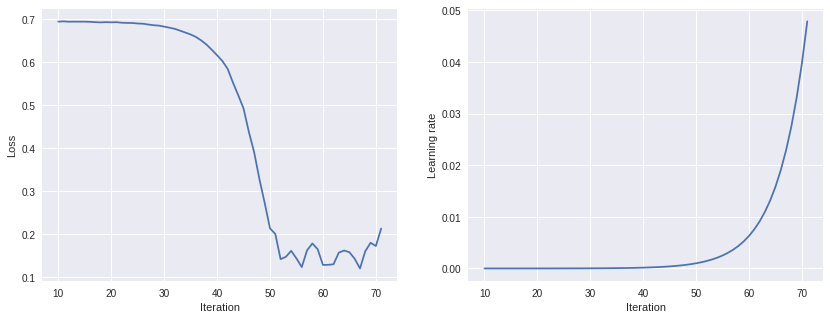

In [0]:
iters = range(len(lrs_log))
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(iters[10:-5], loss_log[10:-5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(iters[10:-5], lrs_log[10:-5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Learning rate')

Text(0, 0.5, 'Loss')

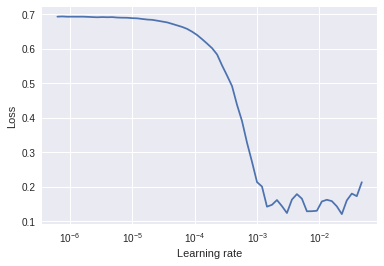

In [0]:
plt.plot(lrs_log[10:-5], loss_log[10:-5])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

### Train in one cycle policy

In [0]:
lr_init = 1e-3
nb_epoch = 5

model = CommentNet(300, 128, vocab_size, embed_mat)
for name, param in model.named_parameters():
    if 'emb' in name:
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_init)
scheduler = OneCycleScheduler(optimizer, nb_epoch, train_loader, max_lr=3e-3, moms=(.8, .7))
solver = NetSolver(model, optimizer, scheduler)

In [0]:
%%time
solver.train_one_cycle(loaders=(train_loader, val_loader), epochs=nb_epoch)


Epoch 1 / 5:


{"metric": "AUC", "value": 0.9761, "epoch": 1}
{"metric": "Val. AUC", "value": 0.9728, "epoch": 1}
{"metric": "Loss", "value": 0.1475, "epoch": 1}
{"metric": "Val. Loss", "value": 0.0592, "epoch": 1}


Epoch 2 / 5:


{"metric": "AUC", "value": 0.9853, "epoch": 2}
{"metric": "Val. AUC", "value": 0.9833, "epoch": 2}
{"metric": "Loss", "value": 0.0483, "epoch": 2}
{"metric": "Val. Loss", "value": 0.0446, "epoch": 2}
updating best val auc...
updating best val loss...


Epoch 3 / 5:


{"metric": "AUC", "value": 0.9901, "epoch": 3}
{"metric": "Val. AUC", "value": 0.9872, "epoch": 3}
{"metric": "Loss", "value": 0.0423, "epoch": 3}
{"metric": "Val. Loss", "value": 0.0416, "epoch": 3}
updating best val auc...
updating best val loss...


Epoch 4 / 5:


{"metric": "AUC", "value": 0.9912, "epoch": 4}
{"metric": "Val. AUC", "value": 0.9885, "epoch": 4}
{"metric": "Loss", "value": 0.0389, "epoch": 4}
{"metric": "Val. Loss", "value": 0.0403, "epoch": 4}
updating best val auc...
updating best val loss...


Epoch 5 / 5:


{"metric": "AUC", "value": 0.9923, "epoch": 5}
{"metric": "Val. AUC", "value": 0.9887, "epoch": 5}
{"metric": "Loss", "value": 0.0369, "epoch": 5}
{"metric": "Val. Loss", "value": 0.0399, "epoch": 5}
updating best val auc...
updating best val loss...

CPU times: user 4min 19s, sys: 2min 41s, total: 7min 1s
Wall time: 7min 6s


In [0]:
# prediction
test_scores = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device=device, dtype=torch.long)
        score = torch.sigmoid(solver.model(x))
        test_scores.append(score.cpu().numpy())
test_scores = np.concatenate(test_scores)

In [0]:
submit = pd.DataFrame(test_scores, columns=label_cols)
submit['id'] = test_df['id']
submit.to_csv('/content/drive/My Drive/DL_projects/toxic_comments/submit.csv', index=False)

In [0]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submit.csv -m "one-cycle, lr=3e-3, 5 epochs"

100% 13.7M/13.7M [00:05<00:00, 2.86MB/s]
Successfully submitted to Toxic Comment Classification Challenge

In [0]:
torch.save(solver.model.state_dict(), 'toxic_comment_model.pth')

### Train normally

In [0]:
lr_init = 1e-3
nb_epoch = 5

model = CommentNet(300, 256, vocab_size, embed_mat)
for name, param in model.named_parameters():
    if 'emb' in name:
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_init)
solver = NetSolver(model, optimizer)

In [0]:
%%time
solver.train(loaders=(train_loader, val_loader), epochs=nb_epoch)


Epoch 1 / 5:


For train set,
For val set,
{"metric": "AUC", "value": 0.9740, "epoch": 1}
{"metric": "Val. AUC", "value": 0.9720, "epoch": 1}
{"metric": "Loss", "value": 0.0944, "epoch": 1}
{"metric": "Val. Loss", "value": 0.0534, "epoch": 1}


Epoch 2 / 5:


For train set,
For val set,
{"metric": "AUC", "value": 0.9775, "epoch": 2}
{"metric": "Val. AUC", "value": 0.9760, "epoch": 2}
{"metric": "Loss", "value": 0.0507, "epoch": 2}
{"metric": "Val. Loss", "value": 0.0490, "epoch": 2}
updating best val auc...
updating best val loss...


Epoch 3 / 5:


For train set,
For val set,
{"metric": "AUC", "value": 0.9848, "epoch": 3}
{"metric": "Val. AUC", "value": 0.9809, "epoch": 3}
{"metric": "Loss", "value": 0.0469, "epoch": 3}
{"metric": "Val. Loss", "value": 0.0457, "epoch": 3}
updating best val auc...
updating best val loss...


Epoch 4 / 5:


For train set,
For val set,
{"metric": "AUC", "value": 0.9862, "epoch": 4}
{"metric": "Val. AUC", "value": 0.9844, "epoch": 4}
{"metric": "Loss", "value": 0.0439, "epoch": 4}
{"metric": "Val. Loss", "value": 0.0440, "epoch": 4}
updating best val auc...
updating best val loss...


Epoch 5 / 5:


For train set,
For val set,
{"metric": "AUC", "value": 0.9877, "epoch": 5}
{"metric": "Val. AUC", "value": 0.9862, "epoch": 5}
{"metric": "Loss", "value": 0.0418, "epoch": 5}
{"metric": "Val. Loss", "value": 0.0422, "epoch": 5}
updating best val auc...
updating best val loss...

CPU times: user 5min 23s, sys: 3min 17s, total: 8min 41s
Wall time: 9min 7s


In [0]:
%%time
solver.train(loaders=(train_loader, val_loader), epochs=1)


Epoch 1 / 1:


For train set,
For val set,
{"metric": "AUC", "value": 0.9904, "epoch": 1}
{"metric": "Val. AUC", "value": 0.9872, "epoch": 1}
{"metric": "Loss", "value": 0.0401, "epoch": 1}
{"metric": "Val. Loss", "value": 0.0414, "epoch": 1}

CPU times: user 1min 27s, sys: 54.1 s, total: 2min 21s
Wall time: 2min 31s


In [0]:
# prediction
test_scores = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device=device, dtype=torch.long)
        score = torch.sigmoid(solver.model(x))
        test_scores.append(score.cpu().numpy())
test_scores = np.concatenate(test_scores)

In [0]:
submit = pd.DataFrame(test_scores, columns=label_cols)
submit['id'] = test_df['id']
submit.to_csv('/content/drive/My Drive/DL_projects/toxic_comments/submit.csv', index=False)

In [0]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submit.csv -m "adam, lr=1e-3, 6 epochs"

100% 13.7M/13.7M [00:04<00:00, 2.95MB/s]
Successfully submitted to Toxic Comment Classification Challenge

### Train normally (finetuning)

In [0]:
for param_group in solver.optimizer.param_groups:
    param_group['lr'] = 1e-4
solver.model.emb.weight.requires_grad = True
solver.optimizer.add_param_group({'params': solver.model.emb.parameters(), 'lr':5e-5})

In [0]:
%%time
solver.train(loaders=(train_loader, val_loader), epochs=2)


Epoch 1 / 2:


For train set,
For val set,
{"metric": "AUC", "value": 0.9912, "epoch": 1}
{"metric": "Val. AUC", "value": 0.9876, "epoch": 1}
{"metric": "Loss", "value": 0.0378, "epoch": 1}
{"metric": "Val. Loss", "value": 0.0407, "epoch": 1}


Epoch 2 / 2:


For train set,
For val set,
{"metric": "AUC", "value": 0.9912, "epoch": 2}
{"metric": "Val. AUC", "value": 0.9879, "epoch": 2}
{"metric": "Loss", "value": 0.0373, "epoch": 2}
{"metric": "Val. Loss", "value": 0.0404, "epoch": 2}
updating best val auc...
updating best val loss...

CPU times: user 3min 15s, sys: 2min 8s, total: 5min 23s
Wall time: 5min 45s


In [0]:
# prediction
test_scores = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device=device, dtype=torch.long)
        score = torch.sigmoid(solver.model(x))
        test_scores.append(score.cpu().numpy())
test_scores = np.concatenate(test_scores)

In [0]:
submit = pd.DataFrame(test_scores, columns=label_cols)
submit['id'] = test_df['id']
submit.to_csv('/content/drive/My Drive/DL_projects/toxic_comments/submit.csv', index=False)

In [0]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submit.csv -m "adam, finetuning, 2 epochs"

100% 13.7M/13.7M [00:06<00:00, 2.23MB/s]
Successfully submitted to Toxic Comment Classification Challenge

## Visualization

In [29]:
model = CommentNet(300, 128, vocab_size)
model.load_state_dict(torch.load('toxic_comment_model.pth'))
device = torch.device('cpu')
model.to(device)
model.eval()

CommentNet(
  (emb): Embedding(60000, 300)
  (dropout_seq): Dropout2d(p=0.25)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (gru): GRU(256, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1)
  (out): Linear(in_features=512, out_features=6, bias=True)
)

In [28]:
[n for n,c in model.named_children()]

['emb', 'dropout_seq', 'lstm', 'gru', 'dropout', 'out']

In [0]:
def extract_features(x, net):
    x = x.to(device)
    features = []
    modules = [m for m in net.children()]
    features.append(modules[0](x))
    features.append(modules[1](features[-1].transpose(1,2).unsqueeze(-1)).squeeze(-1).transpose(1,2))
    features.append(modules[2](features[-1])[0])
    features.append(modules[3](features[-1])[0])
    return [f.cpu().detach().numpy() for f in features]


def normalize_cam(cam):
    cam = cam - np.min(cam)
    return cam / np.max(cam)


def return_cam(features, weights):  # (T, 2*H), (4*H,)
    # generate the class activation maps (CAMs) upsample to 256x256
    D = len(weights)
    cam_avg = weights[:int(D/2)].dot(features.T)  # (T,)
    cam_avg = normalize_cam(cam_avg)
    cam_max = weights[int(D/2):].dot(features.T)  # (T,)
    cam_max = normalize_cam(cam_max)
    return cam_avg, cam_max


def plot_cam(x, y, figsize=(8,4), title=None):
    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)
    
    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2., 0, 1]
    
    if title is not None:
        ax1.set_title(title, color='w')
    
    ax1.imshow(y[None,:], cmap="hot", aspect="auto", extent=extent)
    ax1.set_yticks([])
    ax1.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)
    ax2.set_xlabel('Word position')
    ax2.set_ylabel('Attentive intensity')
    ax2.xaxis.label.set_color('w')
    ax2.yaxis.label.set_color('w')
    ax2.tick_params(axis='x', colors='w')
    ax2.tick_params(axis='y', colors='w')

    plt.tight_layout()
    plt.show()


def see_results(comment, targets):
    # get representations of comment
    final_weights = list(model.parameters())[-2].cpu().detach().numpy()   # (6, 4*H)
    features = extract_features(torch.tensor(comment).unsqueeze(0), model)
    features_rnn = features[-1]   # (1, T, 2*H)
    
    seq_len = len(comment[comment>0])
    print(' '.join([idx_to_word[idx] for idx in comment[comment>0]]))
    print()
    
    for i in range(len(label_cols)):
        # get CAM of review
        cam_avg, cam_max = return_cam(np.squeeze(features_rnn), np.squeeze(final_weights[i]))

        # discard zero paddings
        cam_avg = normalize_cam(cam_avg[-seq_len:])
        cam_max = normalize_cam(cam_max[-seq_len:])

        # print and plot
        print(f'with labels {targets[i].item()}')
        print(f'with prediction prob. {torch.sigmoid(model(torch.tensor(comment).unsqueeze(0)))[0,i].detach().numpy().item()}')
        plot_cam(list(range(seq_len)), (cam_avg+cam_max)/2, title=f"Network attention of '{label_cols[i]}' comment")

In [0]:
# val samples
xs, ys = next(iter(val_loader))
xs, ys = xs.numpy(), ys.numpy()

In [33]:
# samples with positive label
np.where(ys[:,0]==1)[0]

array([   3,   14,   15,   56,   71,   73,   74,   77,   96,  118,  122,
        137,  148,  154,  165,  177,  182,  199,  202,  204,  205,  208,
        213,  229,  245,  247,  251,  261,  271,  273,  313,  321,  322,
        330,  332,  334,  392,  416,  435,  449,  460,  470,  474,  476,
        481,  486,  495,  510,  511,  515,  529,  535,  543,  560,  581,
        582,  588,  590,  599,  608,  610,  626,  631,  632,  646,  653,
        664,  684,  695,  703,  704,  727,  755,  756,  759,  762,  764,
        773,  777,  783,  785,  789,  803,  806,  816,  821,  831,  834,
        835,  873,  878,  903,  908,  910,  912,  913,  935,  967,  996,
        997, 1015])

bye ! don ' t look , come or think of comming back ! tosser .

with labels 1.0
with prediction prob. 0.7166878581047058


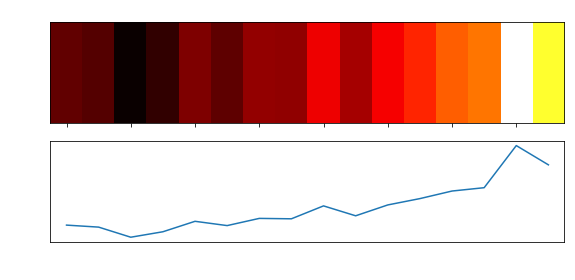

with labels 0.0
with prediction prob. 0.003318074159324169


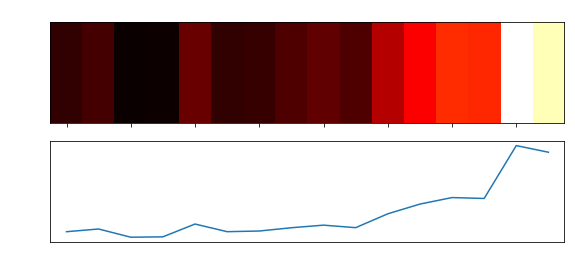

with labels 0.0
with prediction prob. 0.12729346752166748


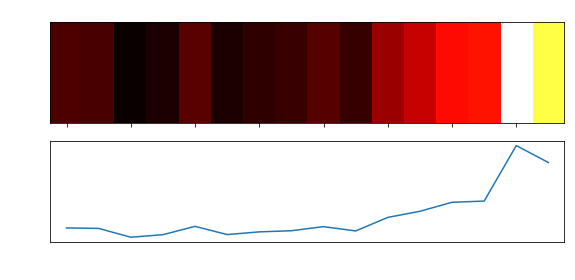

with labels 0.0
with prediction prob. 0.001713776495307684


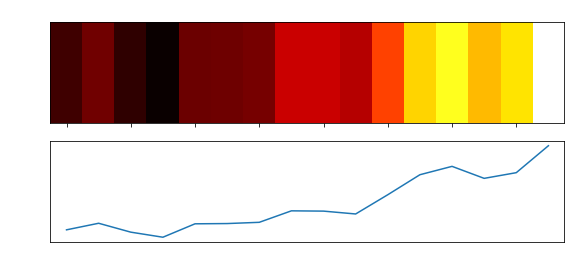

with labels 0.0
with prediction prob. 0.32870686054229736


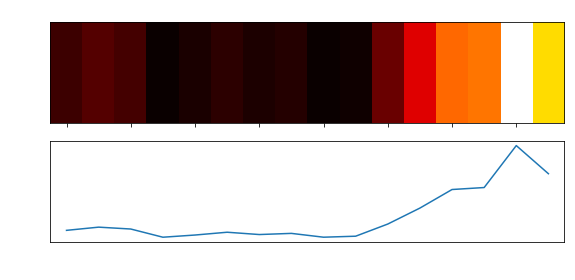

with labels 0.0
with prediction prob. 0.001830061781220138


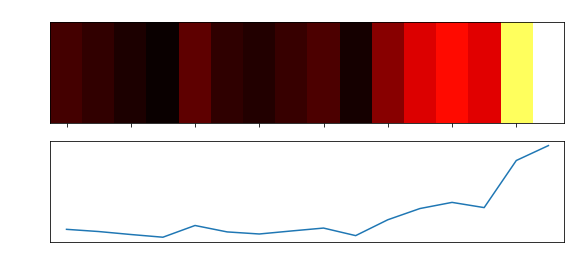

In [61]:
commt = xs[3]
tgs = ys[3]

see_results(commt, tgs)

yes , because the mother of the child in the case against michael jackson was studied in here motives and reasonings and judged upon her character just as harshly as wacko jacko himself . don ' t tell me to ignore it and incriminate myself . i am going to continue refuting the bullshit that jayjg keeps throwing at me . ## : ## , ## jun #### ( utc )

with labels 0.0
with prediction prob. 0.3366647958755493


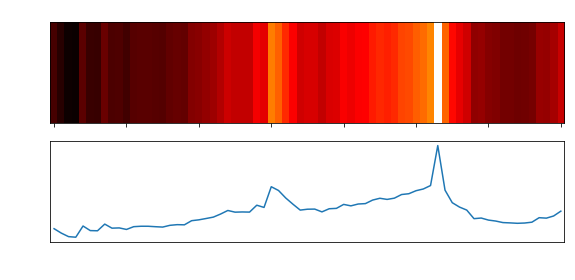

with labels 0.0
with prediction prob. 0.0009597802418284118


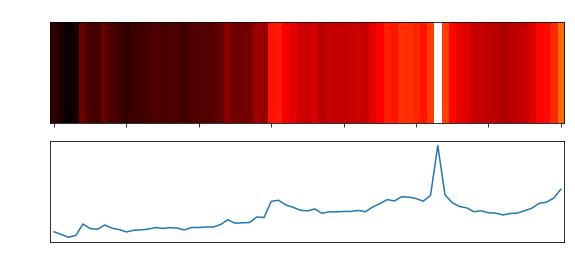

with labels 0.0
with prediction prob. 0.22873641550540924


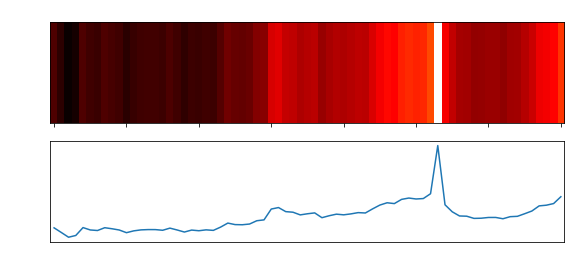

with labels 0.0
with prediction prob. 0.00011514947982504964


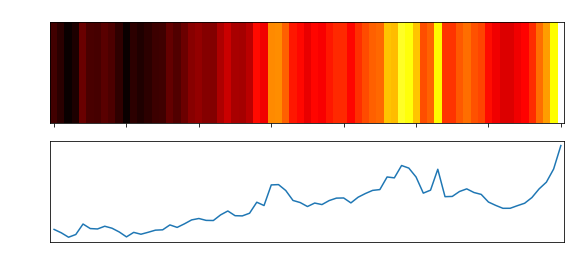

with labels 0.0
with prediction prob. 0.031672634184360504


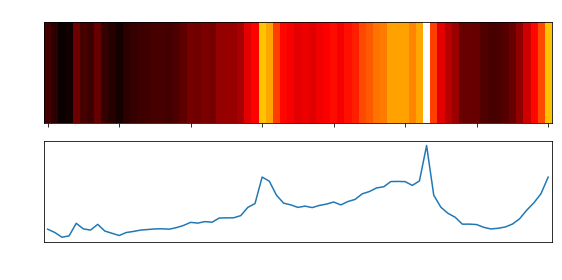

with labels 0.0
with prediction prob. 0.00037350281490944326


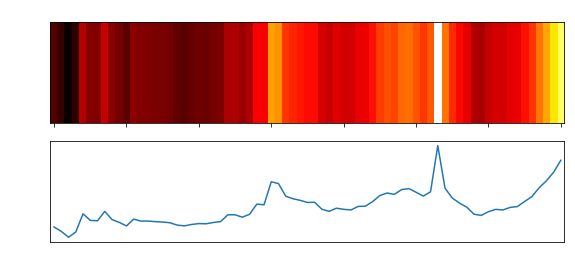

In [62]:
commt = xs[5]
tgs = ys[5]

see_results(commt, tgs)

to hold him back so somebody else could suffer like you ? yes you did . i don ' t make empty threats , so i won ' t be saying anything along the lines of ' i ' ll hurt you ' or ' i ' ll eat the children from within your sister ' s womb ' , but i will say that you are a asshole , son - of - a - bitch , mother fucking cock sucker . so , go eat some more food and drown your sorrows you premature <unk> , bald headed fuck . you should do something nice for yourself , maybe go grab a couple of horny goat weeds from your local convenience store and jack off for a little longer than three minutes tonight . sincerely , an asshole that ' s better than you in every way .

with labels 1.0
with prediction prob. 0.9845615029335022


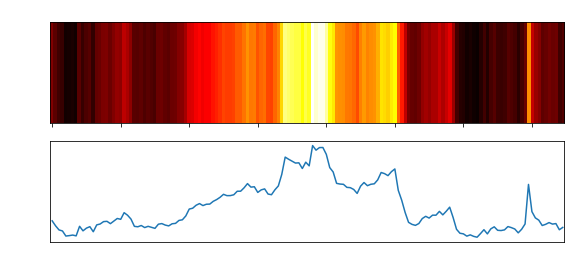

with labels 0.0
with prediction prob. 0.31920167803764343


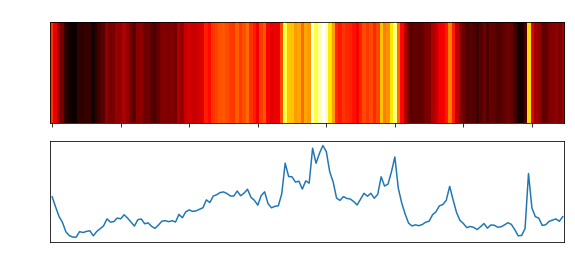

with labels 1.0
with prediction prob. 0.9550008177757263


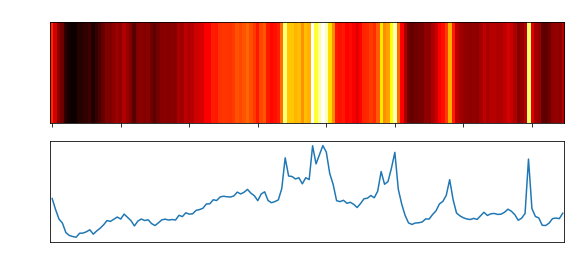

with labels 0.0
with prediction prob. 0.04083031415939331


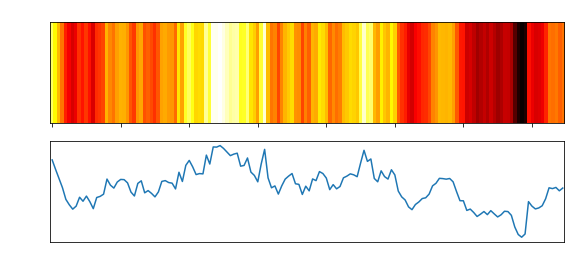

with labels 0.0
with prediction prob. 0.8731995224952698


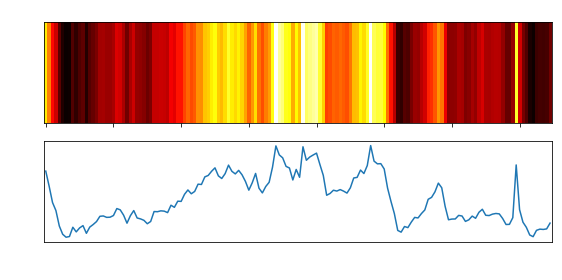

with labels 0.0
with prediction prob. 0.0610903762280941


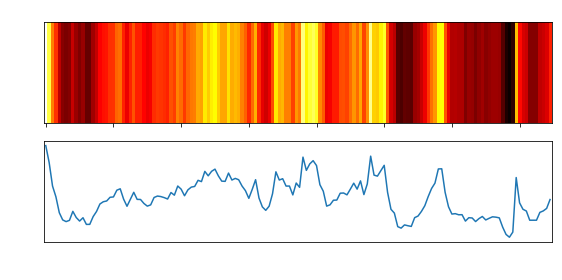

In [63]:
commt = xs[15]
tgs = ys[15]

see_results(commt, tgs)

i went there around the same time he did , and that certainly was not the case at the time . later on they stopped taking children from such a young age .

with labels 0.0
with prediction prob. 0.0010393655393272638


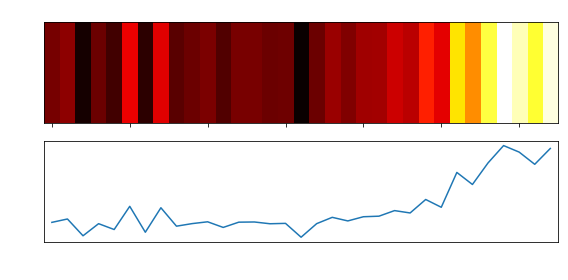

with labels 0.0
with prediction prob. 2.133624002453871e-05


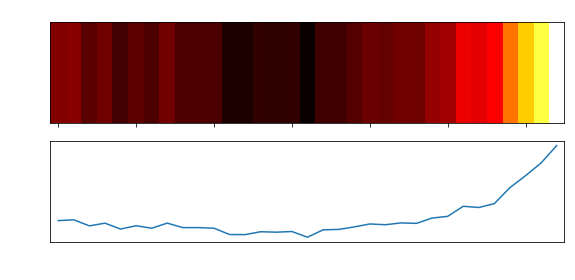

with labels 0.0
with prediction prob. 0.00016526781837455928


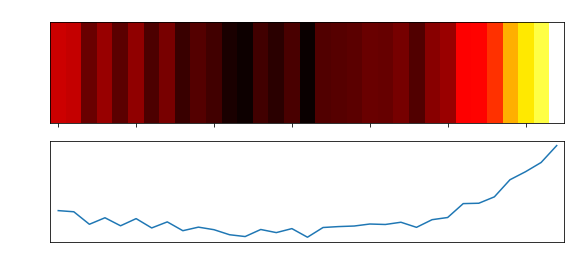

with labels 0.0
with prediction prob. 3.566611485439353e-05


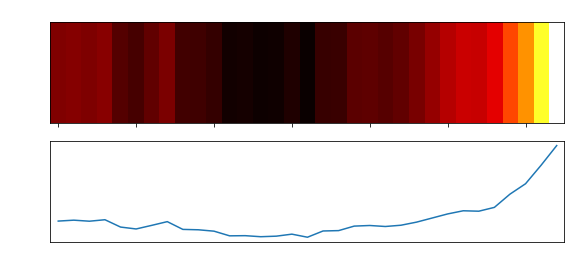

with labels 0.0
with prediction prob. 0.0001800680038286373


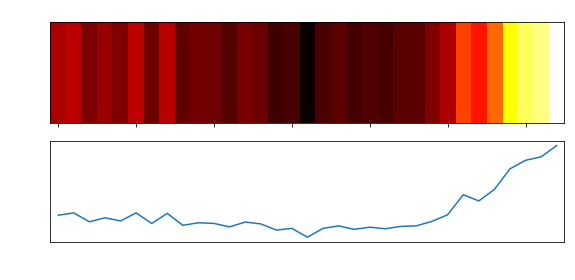

with labels 0.0
with prediction prob. 1.836242518038489e-05


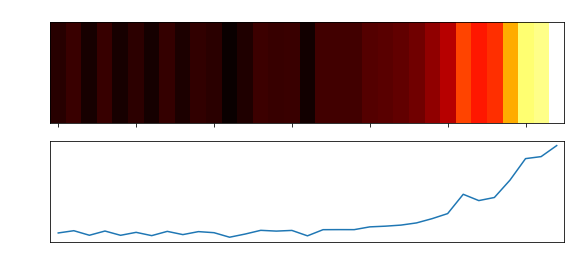

In [64]:
commt = xs[20]
tgs = ys[20]

see_results(commt, tgs)